<a href="https://colab.research.google.com/github/danjonesss/ResearchProject/blob/main/Medical_Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install codecarbon
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.6/174.6 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=750da9608d8437c71da9b1e93f7b71d68250ffd1cca5200c51711da9394e705d
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score
from sklearn.datasets import fetch_openml
import seaborn as sns
from codecarbon import EmissionsTracker
import time
from skimage.color import gray2rgb, rgb2gray, label2rgb
from random import randint
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer
from skimage.segmentation import mark_boundaries
from sklearn.model_selection import train_test_split
import cv2
from sklearn import svm
from google.colab import drive
import os
from PIL import Image
from keras.callbacks import EarlyStopping, ModelCheckpoint
from lime import lime_image
from keras.regularizers import l2

In [10]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        with Image.open(img_path).convert('RGB') as img:
            images.append(np.array(img))
            label = 1 if folder == yes_path else 0
            labels.append(label)
    return images, labels

# Paths to your dataset folders on Google Drive
yes_path = '/content/drive/My Drive/tumor_dataset/demented'
no_path = '/content/drive/My Drive/tumor_dataset/non_demented'

# Loading images and labels from both folders
x_data = []
y_data = []
for folder in [yes_path, no_path]:
    folder_images, folder_labels = load_images_from_folder(folder)
    x_data.extend(folder_images)
    y_data.extend(folder_labels)

x_data = np.array(x_data)
y_data = np.array(y_data)

num_classes = 2



In [11]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size=0.2,
                                                    random_state=42)

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=5,
                              verbose=1,
                              restore_best_weights=True)

ET = EmissionsTracker()
ET.start()
input_shape = (128,128,3)

x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

print("x_train shape:", x_train.shape)
print(x_train.shape[0],"train samples")
print(x_test.shape[0],"test samples")

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),

        layers.Conv2D(32, kernel_size=(3, 3), activation="elu", padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(64, kernel_size=(3, 3), activation="elu", padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Conv2D(128, kernel_size=(3, 3), activation="elu", padding='same'),
        layers.MaxPooling2D(pool_size=(2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation="elu"),
        layers.Dropout(0.5),

        layers.Dense(1, activation="sigmoid"),
    ]
)

model.summary()
batch_size = 32
epochs = 32

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

StartTime = time.time()
history=model.fit(x_train,
                  y_train,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_split=0.1,
                  verbose=1,
                  callbacks=[early_stopping])
emissions: float = ET.stop()
EndTime = time.time() - StartTime

[codecarbon INFO @ 18:31:29] [setup] RAM Tracking...
[codecarbon INFO @ 18:31:29] [setup] GPU Tracking...
[codecarbon INFO @ 18:31:29] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 18:31:29] [setup] CPU Tracking...
[codecarbon WARNING @ 18:31:29] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 18:31:30] We saw that you have a Intel(R) Xeon(R) CPU @ 2.30GHz but we don't know it. Please contact us.
[codecarbon INFO @ 18:31:30] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon INFO @ 18:31:30] >>> Tracker's metadata:
[codecarbon INFO @ 18:31:30]   Platform system: Linux-6.1.58+-x86_64-with-glibc2.35
[codecarbon INFO @ 18:31:30]   Python version: 3.10.12
[codecarbon INFO @ 18:31:30]   CodeCarbon version: 2.3.5
[codecarbon INFO @ 18:31:30]   Available RAM : 12.675 GB
[codecarbon INFO @ 18:31:30]   CPU count: 2
[codecarbon INFO @ 18:31:30]   CPU model: Intel(R) Xeon(R) CPU @ 2.30GHz
[codecarbon INFO @ 18:31:30]   GPU c

x_train shape: (5128, 128, 128, 3)
5128 train samples
1282 test samples
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 32, 32, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 128)       73856     
                                                

[codecarbon INFO @ 18:31:45] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.753046035766602 W
[codecarbon INFO @ 18:31:45] Energy consumed for all GPUs : 0.000244 kWh. Total GPU Power : 58.590579687770834 W
[codecarbon INFO @ 18:31:45] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:31:45] 0.000441 kWh of electricity used since the beginning.


145/145 [==============================] - 3s 22ms/step - loss: 0.1165 - accuracy: 0.9599 - val_loss: 0.2771 - val_accuracy: 0.8830
Epoch 5/32
145/145 [==============================] - 4s 24ms/step - loss: 0.0709 - accuracy: 0.9738 - val_loss: 0.0446 - val_accuracy: 0.9864
Epoch 6/32
145/145 [==============================] - 3s 23ms/step - loss: 0.0147 - accuracy: 0.9959 - val_loss: 0.0232 - val_accuracy: 0.9903
Epoch 7/32
145/145 [==============================] - 3s 22ms/step - loss: 0.0128 - accuracy: 0.9963 - val_loss: 0.0834 - val_accuracy: 0.9630
Epoch 8/32
 91/145 [=================>............] - ETA: 1s - loss: 0.0283 - accuracy: 0.9880

[codecarbon INFO @ 18:32:00] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.753046035766602 W
[codecarbon INFO @ 18:32:00] Energy consumed for all GPUs : 0.000533 kWh. Total GPU Power : 69.39090973894596 W
[codecarbon INFO @ 18:32:00] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:32:00] 0.000928 kWh of electricity used since the beginning.


145/145 [==============================] - 3s 22ms/step - loss: 0.0426 - accuracy: 0.9844 - val_loss: 0.1109 - val_accuracy: 0.9630
Epoch 9/32
145/145 [==============================] - 4s 25ms/step - loss: 0.1572 - accuracy: 0.9456 - val_loss: 0.1626 - val_accuracy: 0.9376
Epoch 10/32
145/145 [==============================] - 3s 23ms/step - loss: 0.0376 - accuracy: 0.9855 - val_loss: 0.0970 - val_accuracy: 0.9747
Epoch 11/32
145/145 [==============================] - 3s 23ms/step - loss: 0.0145 - accuracy: 0.9957 - val_loss: 0.0400 - val_accuracy: 0.9825
Epoch 11: early stopping


[codecarbon INFO @ 18:32:12] Energy consumed for RAM : 0.000055 kWh. RAM Power : 4.753046035766602 W
[codecarbon INFO @ 18:32:12] Energy consumed for all GPUs : 0.000757 kWh. Total GPU Power : 69.51889310422858 W
[codecarbon INFO @ 18:32:12] Energy consumed for all CPUs : 0.000491 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 18:32:12] 0.001304 kWh of electricity used since the beginning.


In [12]:
score = model.evaluate(x_test, y_test, verbose=1)
y_pred = model.predict(x_test)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test,y_pred)
print(cm)
TN = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TP = cm[1][1]

accuracy = ((TP + TN) / (TP + TN + FP + FN))*100
precision = (TP / (TP + FP))*100
recall = (TP / (TP + FN))*100
f1 = (2 * (precision * recall) / (precision + recall))

accuracy = round(accuracy,2)
precision = round(precision,2)
recall = round(recall,2)
f1 = round(f1,2)
print("")
print("Accuracy: ",accuracy,"%")
print("Precision: ",precision,"%")
print("Recall: ",recall,"%")
print("F1 Score: ",f1,"%")

41/41 [==============================] - 0s 8ms/step
[[599   5]
 [ 18 660]]

Accuracy:  98.21 %
Precision:  99.25 %
Recall:  97.35 %
F1 Score:  98.29 %


Test loss: 0.04
Test accuracy: 0.98


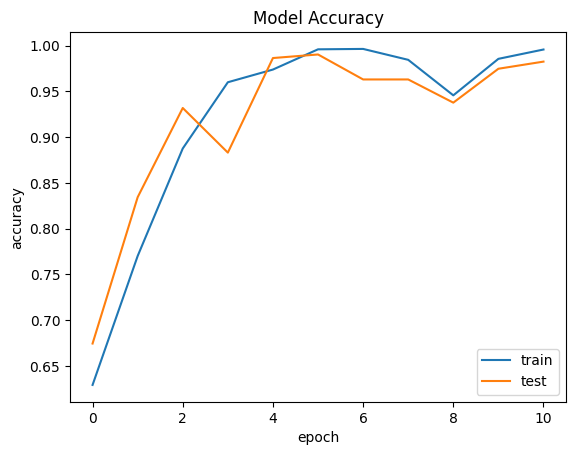


Emissions: 0.0005900885189297868 kg

Time taken:  41.06367063522339 seconds

Accuracy :  98.21 %



In [13]:
print("Test loss:", round(score[0],2))
print("Test accuracy:", round(score[1],2))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
print("")
print(f'Emissions: {emissions} kg')
print("")
print("Time taken: ", EndTime, "seconds")
print("")
print("Accuracy : ", accuracy, "%")
print("")

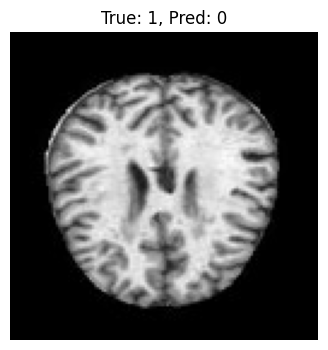

In [15]:
y_pred = y_pred.flatten()
misclassified_indices = np.where(y_test != y_pred)[0]
classified_indices = np.where(y_test == y_pred)[0]
wrong_idx = np.random.choice(misclassified_indices)
right_idx = np.random.choice(classified_indices)
len(misclassified_indices)

def plot_single_misclassified_image(misclassified_indices, x_data, y_true, y_pred):
    if len(misclassified_indices) > 0:
        idx = np.random.choice(misclassified_indices, 1)[0]

        plt.figure(figsize=(6, 4))
        plt.imshow(x_data[idx].reshape(128, 128, 3))
        title = f'True: {y_true[idx]}, Pred: {y_pred[idx]}'
        plt.title(title, fontsize=12)
        plt.axis('off')
        plt.show()
    else:
        print("No misclassified samples found.")

plot_single_misclassified_image(misclassified_indices, x_test, y_test, y_pred)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 19ms/step


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 22ms/step


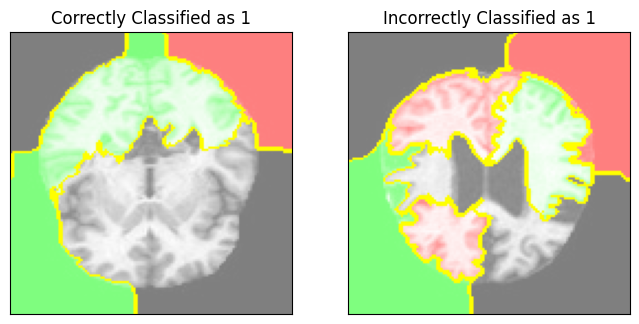

In [16]:
correct = np.random.choice(classified_indices, 1)[0]
incorrect = np.random.choice(misclassified_indices, 1)[0]

explainer = lime_image.LimeImageExplainer()

explanation_correct = explainer.explain_instance(x_test[correct].astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=1000)
temp, mask = explanation_correct.get_image_and_mask(explanation_correct.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title(f'Correctly Classified as {y_pred[correct]}')
plt.xticks([])
plt.yticks([])

explanation_incorrect = explainer.explain_instance(x_test[incorrect].astype('double'), model.predict, top_labels=1, hide_color=0, num_samples=1000)
temp, mask = explanation_incorrect.get_image_and_mask(explanation_incorrect.top_labels[0], positive_only=False, num_features=5, hide_rest=False)
plt.subplot(1,2,2)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.title(f'Incorrectly Classified as {y_pred[incorrect]}')
plt.xticks([])
plt.yticks([])
plt.show()